In [79]:
import torch

# import basic components
import torch.nn as nn

# import functions
import torch.nn.functional as F

# bring optimizers from torch
import torch.optim as optim

# import dataset structuring and image transformation modules
from torchvision import datasets, transforms

from matplotlib import pyplot as plt
%matplotlib inline # matplotlib config for jupyter notebook

UsageError: unrecognized arguments: # matplotlib config for jupyter notebook


In [80]:
# Setting device
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print ('Current cuda device is', device)

Current cuda device is cpu


In [81]:
# Hyperparameter Setting
MINI_BATCH_SIZE = 50 # numbers of images in a mini-batch
LEARNING_RATE = 0.0001
EPOCHS = 15

In [82]:
# Load dataset 
train_data = datasets.MNIST(root = './data', train = True, download = False, transform = transforms.ToTensor())
test_data = datasets.MNIST(root = './data', train = False, transform = transforms.ToTensor())

print('number of training data: ', len(train_data))
print('number of test data: ', len(test_data))

number of training data:  60000
number of test data:  10000


In [83]:
# get image data and label
img_3d_channel, label = train_data[4]

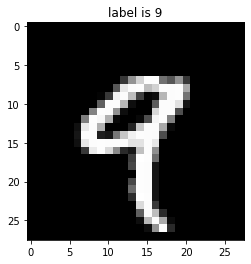

In [84]:
# show image from training data
plt.imshow(img_3d_channel.squeeze().numpy(), cmap = 'gray')
plt.title(f'label is {label}')
plt.show()

In [85]:
# (channel, height, width) = (1, 28, 28)
# channel is 1 because MNIST is grayscale image
print(img_3d_channel.shape)

# change (1, 28, 28) tensor to (28, 28) tensor
# (channel, height, width) -> (height, width)
img_2d_channel = img_3d_channel.squeeze()

# transform tensor format to numpy format
array_sample_image = img_2d_channel.numpy()

# Check shape of the mnist image which is 28 x 28
array_sample_image.shape

torch.Size([1, 28, 28])


(28, 28)

In [86]:
import numpy as np

# check distribution of values in numpy array

print(f"Min: {np.min(array_sample_image)}, Mean:{np.mean(array_sample_image)}, Max: {np.max(array_sample_image)}")

Min: 0.0, Mean:0.11611644923686981, Max: 1.0


In [87]:
# show (maximum - minimum) values along an axis across an array.
# https://www.sharpsightlabs.com/blog/numpy-axes-explained/

COLUMN_AXIS = 0
ROW_AXIS = 1
range_pixels = np.ptp(array_image, axis=COLUMN_AXIS)

# sort range pixels array
# https://rfriend.tistory.com/357
print(np.sort(range_pixels))

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.08627451 0.65882355 0.9882353  0.9882353  0.9882353
 0.9882353  0.9882353  0.9882353  0.99215686 0.99215686 0.99215686
 0.99215686 0.99215686 0.99215686 1.        ]


In [88]:
# using torch dataloader to divide dataset into mini-batch
# https://pytorch.org/docs/stable/data.html
train_loader = torch.utils.data.DataLoader(
  dataset = train_data, 
  batch_size = MINI_BATCH_SIZE, 
  shuffle = True
  )
test_loader  = torch.utils.data.DataLoader(
  dataset = test_data, 
  batch_size = MINI_BATCH_SIZE, 
  shuffle = True
  )

first_batch = train_loader.__iter__().__next__()
# 50 is mini-batch size
print('{:<21s} | {:<25s} | {}'.format('name', 'type', 'size')) # 21s and 25s is character spaces of string
print('{:<21s} | {:<25s} | {}'.format('Number of Mini-Batchs', '', len(train_loader)))
print('{:<21s} | {:<25s} | {}'.format('first_batch', str(type(first_batch)), len(first_batch)))
print('{:<21s} | {:<25s} | {}'.format('first_batch[0]', str(type(first_batch[0])), first_batch[0].shape))
print('{:<21s} | {:<25s} | {}'.format('first_batch[1]', str(type(first_batch[1])), first_batch[1].shape))

name                  | type                      | size
Number of Mini-Batchs |                           | 1200
first_batch           | <class 'list'>            | 2
first_batch[0]        | <class 'torch.Tensor'>    | torch.Size([50, 1, 28, 28])
first_batch[1]        | <class 'torch.Tensor'>    | torch.Size([50])


In [93]:
# Basic Convolutional Neural Network (ConvolutionalNeuralNetwork) Class
class ConvolutionalNeuralNetwork(nn.Module): # extending from nn.Module class
    """ 
    Source: https://github.com/pytorch/examples/blob/master/mnist/main.py
    """
    def __init__(self):
        """ Configuration for the model """
        # Initializing weights for the sake of weights' randomness
        # https://stats.stackexchange.com/questions/45087/why-doesnt-backpropagation-work-when-you-initialize-the-weights-the-same-value
        super(ConvolutionalNeuralNetwork, self).__init__()
        
        # Convolutional Layer configuration
        self.conv1 = nn.Conv2d(
            in_channels = 1, 
            out_channels = 32, 
            kernel_size = 3, 
            stride = 1
        )
        self.conv2 = nn.Conv2d(
            in_channels = 32, 
            out_channels = 64, 
            kernel_size = 3, 
            stride = 1)
        
        # Designating dropout configuration
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        
        # Fully Connected Layers configuration
        self.fc1 = nn.Linear(
            in_features = 9216, 
            out_features = 128
            )
        self.fc2 = nn.Linear(
            in_features = 128, 
            out_features = 10 # MNIST labels 0 ~ 9
            )

    def forward(self, x):
        """ Forward pass of the model using predefined configuration settings on ConvolutionalNeuralNetwork """
        # Stack Convolutional layers
        x = self.conv1(x) # using class' own function
        x = F.relu(x) # using torch.nn.functional function
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        
        # Flattens input by reshaping it into a one-dimensional tensor
        x = torch.flatten(x, start_dim = 1) # using torch's function: https://pytorch.org/docs/stable/generated/torch.flatten.html
        
        # Go through Fully Connected Layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [94]:
# Creating Model instance with preconfigured class
model = ConvolutionalNeuralNetwork().to(device)

# Defining optimizer
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

# Using Cross entropy loss function
criterion = nn.CrossEntropyLoss()

In [95]:
# Print model's architecture
print(model)

ConvolutionalNeuralNetwork(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [97]:
""" Training the model """

# Change the model to training mode
model.train()

# A training step is one gradient update. In one step batch_size many examples are processed.
# training step = dataset size / mini-batch size
# https://stackoverflow.com/questions/38340311/what-is-the-difference-between-steps-and-epochs-in-tensorflow
int_training_step = 1

# Updating Gradient in each training steps
for epoch in range(EPOCHS):
    for data, target_tensor in train_loader: # bringing dataset from train_loader() function
        # data is [Batch Size = 50, Channel Size = 1, Height = 28, Width = 28] tensor
        data = data.to(device)
        # Tagets is label [Labels = 50] tensor
        target_tensor = target_tensor.to(device)
        
        # Gradient Descent process
        optimizer.zero_grad() # initializing previously saved gradient's value to zero # https://jaeyung1001.tistory.com/115
        output = model(data) # feed forward to get one-hot-encoded output probabilities
        loss = criterion(output, target_tensor) # comparing prediction and ground truth to get loss
        loss.backward() # backpropagating loss
        optimizer.step() # updating weights with single optimization step

        # print status every 1000 training steps
        if int_training_step % 1000 == 0:
            loss_rounded_to_3 = round(loss.item() * 1000) / 1000 # loss is a single value, so we need to round it to 3 digits
            print(f'Train Step: {int_training_step} \t Loss: {loss_rounded_to_3}')
        int_training_step += 1

Train Step: 1000 	 Loss: 0.573
Train Step: 2000 	 Loss: 0.239
Train Step: 3000 	 Loss: 0.197
Train Step: 4000 	 Loss: 0.062
Train Step: 5000 	 Loss: 0.21
Train Step: 6000 	 Loss: 0.039
Train Step: 7000 	 Loss: 0.016
Train Step: 8000 	 Loss: 0.084
Train Step: 9000 	 Loss: 0.008
Train Step: 10000 	 Loss: 0.05
Train Step: 11000 	 Loss: 0.062
Train Step: 12000 	 Loss: 0.042
Train Step: 13000 	 Loss: 0.066
Train Step: 14000 	 Loss: 0.077
Train Step: 15000 	 Loss: 0.129
Train Step: 16000 	 Loss: 0.007
Train Step: 17000 	 Loss: 0.015
Train Step: 18000 	 Loss: 0.07


In [101]:
""" Evaluating the model """

# Switching to evaluation mode
model.eval()

correct = 0
for data, target_labels in test_loader:    
    # data is [Batch Size = 50, Channel Size = 1, Height = 28, Width = 28] tensor
    data = data.to(device)
    # Tagets is label [Labels = 50] tensor
    target_labels = target_labels.to(device)
    
    # getting predicted output label out of maximum probabilities' output in the tensor
    output = model(data)
    predicted_output_labels = output.data.max(1)[1]

    # add numbers of correct predictions
    correct += predicted_output_labels.eq(target_labels.data).sum()

print('Test set: Accuracy: {:.2f}%'.format(100. * correct / len(test_loader.dataset)))

Test set: Accuracy: 98.91%


In [102]:
correct

tensor(9891)

In [103]:
prediction.eq(target.data)

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True])